In [10]:
!pip install spotipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [192]:
import pandas as pd
from tabulate import tabulate
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from bs4 import BeautifulSoup
import requests
import json
import spotipy
import pandas as pd
from spotipy.oauth2 import SpotifyClientCredentials

In [193]:
# Import necessary libraries
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.ml.feature import StopWordsRemover, Tokenizer, CountVectorizer
from pyspark.ml.classification import NaiveBayes
from pyspark.ml import Pipeline
from nltk.sentiment import SentimentIntensityAnalyzer


In [194]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer

# Create a SparkSession
spark = SparkSession.builder.appName('SentimentAnalysis').getOrCreate()

In [196]:
#SPOTIFY AUTHENCATION
# setting up authorization
cid ="0c9e9230b6374a859a69fe469cef288c" 
secret = "9d8909c7682f4d9387343da9ed0b782a"

AUTH_URL = 'https://accounts.spotify.com/api/token'


client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

# Fetching an access token using the client credentials flow
auth_response = requests.post(AUTH_URL, {
    'grant_type': 'client_credentials',
    'client_id': cid,
    'client_secret': secret,
})
access_token = auth_response.json()['access_token']

# Setting up headers with access token
headers = {
    'Authorization': f'Bearer {access_token}'
}

In [197]:
# Musixmatch API setup
# your api key
api_key = "b9812fb4465db29e247de1c20479ecf1"

# base url and method
base_url = "https://api.musixmatch.com/ws/1.1/"
method = "matcher.lyrics.get"

In [256]:
# Function to get track info from Spotify
def get_track_info(url):
    # Extract track ID from URL
    track_id = url.split('/')[-1].split('?')[0]
    
    # Use Spotipy library to get track info
    track_info = sp.track(track_id)
    
    # Extract relevant fields from track info
    name = track_info['name']
    artists = [artist['name'] for artist in track_info['artists']]
    duration_ms = track_info['duration_ms']
    release_date = track_info['album']['release_date']
    explicit = track_info['explicit']
    track_number = track_info['track_number']
    
    # Get the track audio features
    audio_features = sp.audio_features(tracks=[track_id])[0]
    danceability = audio_features['danceability']
    energy = audio_features['energy']
    key = audio_features['key']
    loudness = audio_features['loudness']
    speechiness = audio_features['speechiness']
    acousticness = audio_features['acousticness']
    instrumentalness = audio_features['instrumentalness']
    liveness = audio_features['liveness']
    valence = audio_features['valence']
    tempo = audio_features['tempo']
    
    return name, artists, duration_ms, release_date, explicit, track_number, danceability, energy, key, loudness, speechiness, acousticness, instrumentalness, liveness, valence, tempo

def get_artist_id(track_id):
    # Use Spotipy library to get track info
    track_info = sp.track(track_id)
    # Extract artist ID from track info
    artist_id = track_info['artists'][0]['id']
    return artist_id

def get_artist_top_tracks(artist_id):
    # Use Spotipy library to get artist's top tracks
    top_tracks = sp.artist_top_tracks(artist_id)
    # Extract relevant fields from top tracks
    track_names = [track['name'] for track in top_tracks['tracks']]
    track_ids = [track['id'] for track in top_tracks['tracks']]
    durations = [track['duration_ms'] for track in top_tracks['tracks']]
    explicit = [track['explicit'] for track in top_tracks['tracks']]
    track_numbers = [track['track_number'] for track in top_tracks['tracks']]
    danceability = [sp.audio_features(track['id'])[0]['danceability'] for track in top_tracks['tracks']]
    energy = [sp.audio_features(track['id'])[0]['energy'] for track in top_tracks['tracks']]
    key = [sp.audio_features(track['id'])[0]['key'] for track in top_tracks['tracks']]
    loudness = [sp.audio_features(track['id'])[0]['loudness'] for track in top_tracks['tracks']]
    speechiness = [sp.audio_features(track['id'])[0]['speechiness'] for track in top_tracks['tracks']]
    acousticness = [sp.audio_features(track['id'])[0]['acousticness'] for track in top_tracks['tracks']]
    instrumentalness = [sp.audio_features(track['id'])[0]['instrumentalness'] for track in top_tracks['tracks']]
    liveness = [sp.audio_features(track['id'])[0]['liveness'] for track in top_tracks['tracks']]
    valence = [sp.audio_features(track['id'])[0]['valence'] for track in top_tracks['tracks']]
    tempo = [sp.audio_features(track['id'])[0]['tempo'] for track in top_tracks['tracks']]
    popularity = [track['popularity'] for track in top_tracks['tracks']]
    return track_names, track_ids, durations, explicit, track_numbers, danceability, energy, key, loudness, speechiness, acousticness, instrumentalness, liveness, valence, tempo, popularity


def get_artist_followers(artist_id):
    # Use Spotipy library to get artist's followers
    artist_info = sp.artist(artist_id)
    followers = artist_info['followers']['total']
    return followers

def get_artist_albums(artist_id):
    # Use Spotipy library to get artist's albums
    albums = sp.artist_albums(artist_id)
    # Extract relevant fields from albums
    album_names = [album['name'] for album in albums['items']]
    album_ids = [album['id'] for album in albums['items']]
    return album_names, album_ids

# Function to get lyrics from Musixmatch API
def get_lyrics(artist_name, track_name):
    # Use Musixmatch API to get lyrics
    query_params = {
        "q_artist": artist_name,
        "q_track": track_name,
        "apikey": api_key
    }
    api_call = requests.get(base_url + method, params=query_params)

    # Check if the request was successful
    if api_call.status_code == 200:
        response = json.loads(api_call.content)
        # Check if there are lyrics available
        if response["message"]["header"]["status_code"] == 200:
            lyrics = response["message"]["body"]["lyrics"]["lyrics_body"]
            return lyrics
        else:
            return "Lyrics not found for the specified song."
    else:
        return "Error in API request."

# Prompt user for Spotify track URL
url = input("Enter a Spotify track URL: ")

# Get track info from Spotify
track_info = get_track_info(url)
track_id = url.split('/')[-1].split('?')[0]
track_name, artist_name, duration_ms, release_date, explicit, track_number, danceability, energy, key, loudness, speechiness, acousticness, instrumentalness, liveness, valence, tempo = track_info

# Get lyrics from Musixmatch API
lyrics = get_lyrics(artist_name[0], track_name)

# Get artist ID
artist_id = get_artist_id(track_id)

# Get artist's top tracks
top_tracks = get_artist_top_tracks(artist_id)
top_tracks = track_names, track_ids, durations, explicit, track_numbers, danceability, energy, key, loudness, speechiness, acousticness, instrumentalness, liveness, valence, tempo, popularity

#Get artist's followers
followers = get_artist_followers(artist_id)

#Get artist's albums
albums = get_artist_albums(artist_id)
album_names, album_ids = albums


Enter a Spotify track URL: https://open.spotify.com/track/5QO79kh1waicV47BqGRL3g?si=0eb06a2ba91f4819


In [257]:
print(followers)
print(lyrics)

61191931
Ooh
Na-na, yeah

I saw you dancing in a crowded room (uh)
You look so happy when I'm not with you
But then you saw me, caught you by surprise
A single teardrop falling from your eye

I don't know why I run away

I make you cry when I run away

You could've asked me why I broke your heart
You could've told me that you fell apart
But you walked past me like I wasn't there
And just pretended like you didn't care

...

******* This Lyrics is NOT for Commercial use *******
(1409623214746)


In [258]:
import pandas as pd
from pyspark.sql import SparkSession

from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, BooleanType

# Create SparkSession object
spark = SparkSession.builder.appName("spotify").getOrCreate()

# Create pandas DataFrame
df_track_info = pd.DataFrame([track_info], columns=['name', 'artists', 'duration_ms', 'release_date', 'explicit', 'track_number', 'danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'])

# Create PySpark DataFrame
spark = SparkSession.builder.appName("TrackInfo").getOrCreate()
df_track_info_spark = spark.createDataFrame(df_track_info)
df_track_info_spark.show()

+---------------+------------+-----------+------------+--------+------------+------------+------+---+--------+-----------+------------+----------------+--------+-------+-------+
|           name|     artists|duration_ms|release_date|explicit|track_number|danceability|energy|key|loudness|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|
+---------------+------------+-----------+------------+--------+------------+------------+------+---+--------+-----------+------------+----------------+--------+-------+-------+
|Save Your Tears|[The Weeknd]|     215626|  2020-03-20|    true|          11|        0.68| 0.826|  0|  -5.487|     0.0309|      0.0212|         1.24E-5|   0.543|  0.644|118.051|
+---------------+------------+-----------+------------+--------+------------+------------+------+---+--------+-----------+------------+----------------+--------+-------+-------+



In [259]:
import pandas as pd

# Get artist's top tracks
top_tracks = get_artist_top_tracks(artist_id)

# Convert to pandas DataFrame
df_top_tracks = pd.DataFrame({
    'Track Name': top_tracks[0],
    'Track ID': top_tracks[1],
    'Duration (ms)': top_tracks[2],
    'Explicit': top_tracks[3],
    'Track Number': top_tracks[4],
    'Danceability': top_tracks[5],
    'Energy': top_tracks[6],
    'Key': top_tracks[7],
    'Loudness': top_tracks[8],
    'Speechiness': top_tracks[9],
    'Acousticness': top_tracks[10],
    'Instrumentalness': top_tracks[11],
    'Liveness': top_tracks[12],
    'Valence': top_tracks[13],
    'Tempo': top_tracks[14],
    'Popularity': top_tracks[15]
})

# Convert Pandas DataFrame to PySpark DataFrame
df_top_tracks_spark = spark.createDataFrame(df_top_tracks)

# Show DataFrame
df_top_tracks_spark.show()

+--------------------+--------------------+-------------+--------+------------+------------+------+---+--------+-----------+------------+----------------+--------+-------+-------+----------+
|          Track Name|            Track ID|Duration (ms)|Explicit|Track Number|Danceability|Energy|Key|Loudness|Speechiness|Acousticness|Instrumentalness|Liveness|Valence|  Tempo|Popularity|
+--------------------+--------------------+-------------+--------+------------+------------+------+---+--------+-----------+------------+----------------+--------+-------+-------+----------+
|Die For You (with...|4W4fNrZYkobj539TO...|       232857|   false|          19|       0.575|   0.5|  1|  -7.594|     0.0707|       0.227|             0.0|   0.335|  0.506| 67.033|        73|
|Creepin' (with Th...|2dHHgzDwk4BJdRwy9...|       221520|    true|          10|       0.715|  0.62|  1|  -6.005|     0.0484|       0.417|             0.0|  0.0822|  0.172|  97.95|        95|
|         Die For You|2LBqCSwhJGcFQeTHM...|  

In [260]:
# Convert to pandas DataFrame
df_albums = pd.DataFrame({'album_name': album_names, 'album_id': album_ids})

# Convert Pandas DataFrame to PySpark DataFrame
df_albums_spark= spark.createDataFrame(df_albums)

# Show PySpark DataFrame
df_albums_spark.show()

+--------------------+--------------------+
|          album_name|            album_id|
+--------------------+--------------------+
|    Starboy (Deluxe)|35dut3ICqF3NEDkjx...|
|    Starboy (Deluxe)|24PQTJnB3I08bK8fT...|
|Live At SoFi Stadium|1OARrXe5sB0gyy3Mh...|
|Live At SoFi Stadium|2DXQMbPFn4GBcXDBo...|
|Live At SoFi Stadium|0UKezqSisauPVMHTS...|
|Avatar: The Way o...|4M2Mf4pmARKGVT9ML...|
|Dawn FM (Alternat...|12INlMsFtBjyehNna...|
|Dawn FM (Alternat...|0A8SNVB9aIWEW3rm2...|
|Dawn FM (Alternat...|3esNgb0dchNmQ3Mhl...|
|Dawn FM (Alternat...|4ixmmZ1fUOvfZtVts...|
|             Dawn FM|1bupWi00723vxZoS7...|
|             Dawn FM|2nLOHgzXzwFEpl62z...|
|After Hours (Deluxe)|6YlDIxqEjvY63ffH6...|
|After Hours (Deluxe)|5OrhhWHH015Al0f85...|
|After Hours (Deluxe)|742eAldb4AJKLoPgJ...|
|After Hours (Deluxe)|4ZyeHIgdujClXSjC2...|
|         After Hours|4yP0hdKOZPNshxUOj...|
|         After Hours|03NCvBIGqzLPhLoi4...|
| My Dear Melancholy,|4qZBW3f2Q8y0k1A84...|
| My Dear Melancholy,|3iv1Dt4wzw

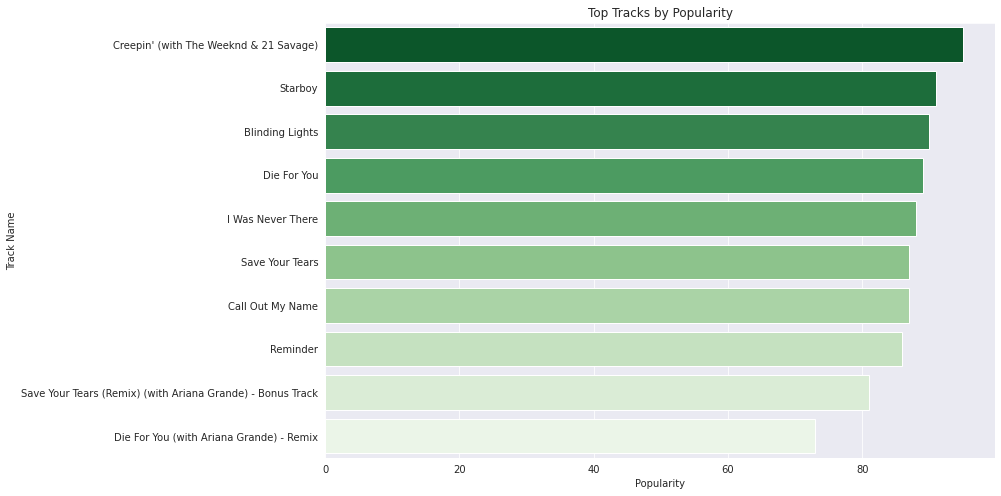

In [261]:
from pyspark.sql.functions import desc

# Sort tracks by popularity in descending order
sorted_tracks = df_top_tracks_spark.orderBy(desc("Popularity"))

import seaborn as sns
import matplotlib.pyplot as plt

# Get the count of rows in the DataFrame
num_tracks = sorted_tracks.count()

# Set the color palette
colors = sns.color_palette("Greens_r", num_tracks).as_hex()

# Create the bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x="Popularity", y="Track Name", data=sorted_tracks.toPandas(), palette=colors)

# Set the x-label and y-label
plt.xlabel("Popularity")
plt.ylabel("Track Name")

# Set the title
plt.title("Top Tracks by Popularity")

# Show the plot
plt.show()

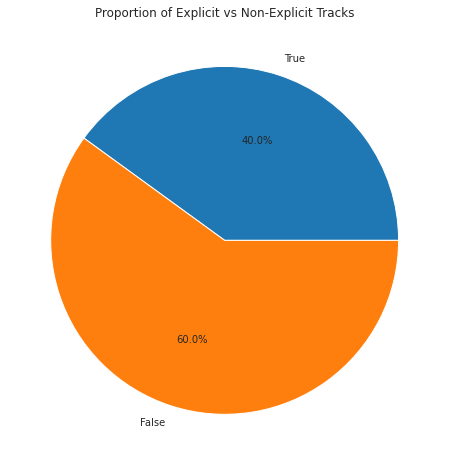

In [262]:
from pyspark.sql.functions import count

# Group by the Explicit column and count the number of rows for each value
explicit_counts = df_top_tracks_spark.groupBy('Explicit').agg(count('*').alias('count'))

# Convert the result to a pandas DataFrame
explicit_counts_df = explicit_counts.toPandas()

# Create a pie chart of explicit vs non-explicit tracks
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 8))
plt.pie(explicit_counts_df['count'], labels=explicit_counts_df['Explicit'], autopct='%1.1f%%')
plt.title('Proportion of Explicit vs Non-Explicit Tracks')
plt.show()

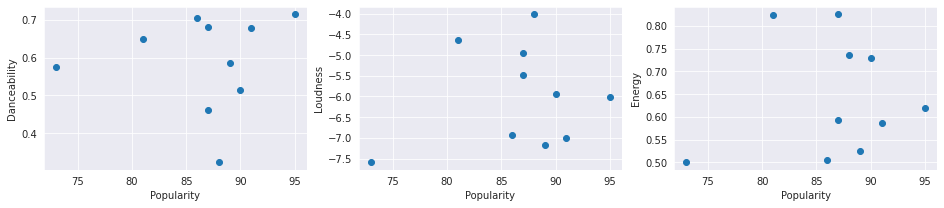

In [263]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

# Select the columns for the scatter plots
popularity = "Popularity"
danceability = "Danceability"
loudness = "Loudness"
energy = "Energy"

# Convert the columns to PySpark columns
popularity_col = col(popularity)
danceability_col = col(danceability)
loudness_col = col(loudness)
energy_col = col(energy)

# Create the scatter plots
plt.figure(figsize=(16, 3))

# Popularity vs Danceability
plt.subplot(1, 3, 1)
plt.scatter(df_top_tracks_spark.select(popularity_col).collect(),
            df_top_tracks_spark.select(danceability_col).collect())
plt.xlabel(popularity)
plt.ylabel(danceability)

# Popularity vs Loudness
plt.subplot(1, 3, 2)
plt.scatter(df_top_tracks_spark.select(popularity_col).collect(),
            df_top_tracks_spark.select(loudness_col).collect())
plt.xlabel(popularity)
plt.ylabel(loudness)

# Popularity vs Energy
plt.subplot(1, 3, 3)
plt.scatter(df_top_tracks_spark.select(popularity_col).collect(),
            df_top_tracks_spark.select(energy_col).collect())
plt.xlabel(popularity)
plt.ylabel(energy)

plt.show()

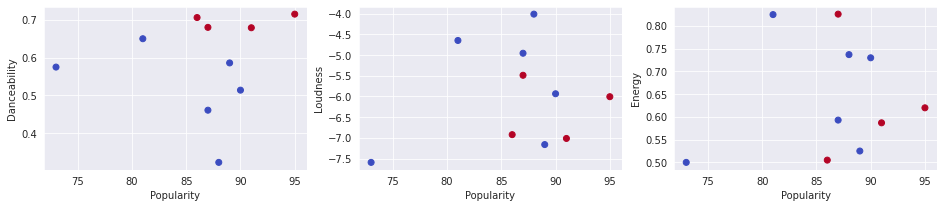

In [264]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import col

# Select the columns for the scatter plots
popularity = "Popularity"
danceability = "Danceability"
loudness = "Loudness"
energy = "Energy"
explicit = "Explicit"

# Convert the columns to PySpark columns
popularity_col = col(popularity)
danceability_col = col(danceability)
loudness_col = col(loudness)
energy_col = col(energy)
explicit_col = col(explicit)

# Get the explicitness values as a NumPy array
explicit_arr = np.array(df_top_tracks_spark.select(explicit_col).collect()).flatten()

# Create the scatter plots
fig, axs = plt.subplots(1, 3, figsize=(16, 3))

# Popularity vs Danceability
axs[0].scatter(df_top_tracks_spark.select(popularity_col).collect(),
               df_top_tracks_spark.select(danceability_col).collect(),
               c=explicit_arr, cmap='coolwarm')
axs[0].set_xlabel(popularity)
axs[0].set_ylabel(danceability)

# Popularity vs Loudness
axs[1].scatter(df_top_tracks_spark.select(popularity_col).collect(),
               df_top_tracks_spark.select(loudness_col).collect(),
               c=explicit_arr, cmap='coolwarm')
axs[1].set_xlabel(popularity)
axs[1].set_ylabel(loudness)

# Popularity vs Energy
axs[2].scatter(df_top_tracks_spark.select(popularity_col).collect(),
               df_top_tracks_spark.select(energy_col).collect(),
               c=explicit_arr, cmap='coolwarm')
axs[2].set_xlabel(popularity)
axs[2].set_ylabel(energy)

plt.show()


In [265]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Create a PySpark DataFrame with a single row containing the lyrics column
df_lyrics = spark.createDataFrame([(lyrics,)], ['lyrics'])

In [266]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import nltk
import string
import re

# Define the UDF to preprocess the lyrics
@udf(StringType())
def preprocess_lyrics(lyrics):
    # Tokenize the lyrics
    tokens = lyrics.split()
    
    # Convert to lowercase
    tokens = [word.lower() for word in tokens]

    # Remove stopwords and punctuation
    stop_words = set(nltk.corpus.stopwords.words('english'))
    punctuation = set(string.punctuation)
    cleaned_tokens = [word for word in tokens if word not in stop_words and word not in punctuation]

    # Join the cleaned tokens back into a string
    cleaned_lyrics = " ".join(cleaned_tokens)
    
    # Remove punctuation marks
    cleaned_lyrics = re.sub(r'[^\w\s]','', cleaned_lyrics)
    
    return cleaned_lyrics

# Apply the UDF to the lyrics column in the PySpark DataFrame
df_lyrics = df_lyrics.withColumn('preprocessed_lyrics', preprocess_lyrics(df_lyrics['lyrics']))

# Show the preprocessed lyrics
df_lyrics.select('preprocessed_lyrics').show(truncate=False)


+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|preprocessed_lyrics                                                                                                                                                                                                                                                     |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ooh nana yeah saw dancing crowded room uh look happy im saw me caught surprise single teardrop falling eye know run away make cry run away couldve asked broke heart couldve told fell apart walked pa

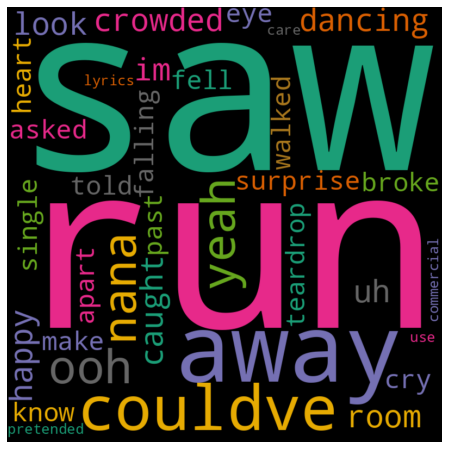

In [267]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Extract the preprocessed lyrics from the PySpark DataFrame
preprocessed_lyrics = df_lyrics.select('preprocessed_lyrics').collect()[0][0]

# Generate the word cloud
wordcloud = WordCloud(background_color='black', colormap='Dark2', width=800, height=800).generate(preprocessed_lyrics)

# Plot the word cloud
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

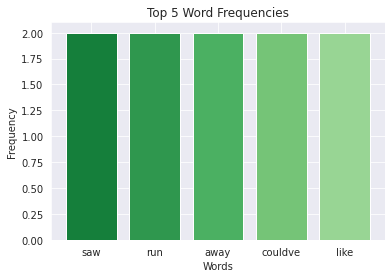

In [268]:
from collections import Counter
import matplotlib.pyplot as plt

# Split the preprocessed lyrics into words
words = preprocessed_lyrics.split()

# Count the frequency of each word and get the top 5
word_freq = Counter(words).most_common(5)

# Extract the words and frequencies into separate lists
words = [word[0] for word in word_freq]
freqs = [word[1] for word in word_freq]

# Create a bar plot of the word frequencies
plt.bar(words, freqs, color=plt.cm.Greens_r([0.2, 0.3, 0.4, 0.5, 0.6]))
plt.title('Top 5 Word Frequencies')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()